In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

import json
from pathlib import Path
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize , sent_tokenize
# spacy for lemmatization
import spacy
import numpy as np

stop_words = set(stopwords.words('english')) 
num_topics = 10
tfidf_vectorizer = TfidfVectorizer()
nmf = NMF(n_components=num_topics, random_state=1, alpha=.1, l1_ratio=.5)
nlp = spacy.load('en', disable=['parser', 'ner'])

In [2]:
import re

def lemmatization(nlp, texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        sent_new = ''
        doc = nlp(sent) 
        sent_lemma = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        for word in sent_lemma:
            sent_new += word + ' '
        texts_out.append(sent_new)
    return texts_out

def get_preprocessed_text(bookpath, wordlen_thresh=2):
    preprocessed_sents = []
    preprocessed_sents_per_chapter = {}
    with open(bookpath) as book_json:
        chapter_par_dict = json.load(book_json)
        
        # for chapter, paragraphs in book
        for chapter, pars in chapter_par_dict.items():
            preprocessed_sents_per_chapter[chapter] = []
            
            # For actual paragraph in chapter
            for par in pars:
                sents = sent_tokenize(par)
                for sentence in sents:
                    sent = re.sub(r'\s+', ' ', sentence)  # remove newline chars
                    sent = re.sub(r'\"', '', sent)  # remove single quotes
                    sent = re.sub(r"\'", '', sent)  # remove single quotes
                    sent = re.sub(r"\*", '', sent)  # remove * in text
                    
                    # Remove stop words from sentence using nltk stopword list
                    sent_wo_stopwords = [word.strip() for word in word_tokenize(sent) if word.strip() not in stop_words]
                    
                    # Remove words that are smaller than given threshold (like J K R O W L I N G)
                    sent_wo_small = [word.strip() for word in sent_wo_stopwords if len(word.strip()) >= wordlen_thresh]
                    sent = ''
                    for word in sent_wo_small:
                        sent += word + ' '
                    preprocessed_sents.append(sent)
                    preprocessed_sents_per_chapter[chapter].append(sent)
    return preprocessed_sents, preprocessed_sents_per_chapter

In [61]:
import pandas as pd

def get_nmf_topics(model, features, n_top_words):
    '''
        get pandas dataframe that contains topics as columns and rows with n_top_words words ordered by their importance from nmf
    '''
    
    # the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = features
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict[f'Topic #{i:02d}'] = words;
    
    return pd.DataFrame(word_dict), word_dict

In [86]:
import time
from itertools import combinations

bookPaths = Path('../data/books_json')
books = [book for book in bookPaths.iterdir() if 'book_' in book.name]

with open('../data/chapters/chapter_numbers.json') as chapter_numerated:
    chapter_numbers = json.load(chapter_numerated)

for book in books:
    start = time.time()
    print(f'==> Start with {book.name}')
    book_compl, book_chapters = get_preprocessed_text(str(book))
    
    print('    ==> Lemmatization complete book')
    lemmatized = lemmatization(nlp, book_compl)
    print('    ==> TFIDF & NMF complete book')
    tfidf_all = tfidf_vectorizer.fit_transform(lemmatized)
    #print(pairwise_distances(tfidf_all, metric='cosine').shape)
    
    nmf_model = nmf.fit(tfidf_all)
    features = tfidf_vectorizer.get_feature_names()
    c = tfidf_vectorizer.vocabulary_['say']
    print(tfidf_all[:,c][np.nonzero(tfidf_all[:,c].todense())])
    #tfidf_df = pd.DataFrame(tfidf_all.toarray(), columns = features)    
    #print(feature_scores)
    
    topic_df, topic_dict = get_nmf_topics(nmf_model, features, 10)
    coherence_score = 0
    topic_tfidfs = []
    for wordlist in topic_dict.values():
        for pair in combinations(wordlist, 2):
            tfidf_p1 = tfidf_vectorizer.transform([pair[0]])
            tfidf_p2 = tfidf_vectorizer.transform([pair[1]])
     #       print(tfidf_p1, tfidf_p2)
      #      print('------')
            dist = cosine_similarity(tfidf_p1, tfidf_p2)
       #     print(dist)
            dist = np.sum(dist)/len(dist)
            coherence_score+=dist
    coherence_score /= num_topics
    #print(coherence_score)
    
    topic_df.to_csv(f'../data/topics/topics_by_book_{book.name[:-5]}.csv', header=True)
    
    print('    ==> Processing Chapters')
    chapter_lemma = lemmatization(nlp, book_chapters.values())
    chapter_tfidf = tfidf_vectorizer.transform(chapter_lemma)
    W = nmf.transform(chapter_tfidf)
    chapter_W = {}
    for no, chapter in enumerate(book_chapters.keys()):
        chapter_W[chapter] = W[no, :]

    chapter_df =  pd.DataFrame(columns=['chapter_no','topic_no', 'topic_prob'])
    idx = 0
    for chapter, W_mat in chapter_W.items():
        for i in range(num_topics):
            chapter_no = chapter_numbers[chapter]+2000
            topic_prob = W_mat[i]
            topic_dict = {f'chapter_no':chapter_no, 'topic_no': i, 'topic_prob': topic_prob}
            chapter_df = chapter_df.append(topic_dict, ignore_index=True)

    #chapter_df =chapter_df.set_index(['chapter_no',)
    #print(chapter_df)
    chapter_df.to_csv(f'../data/topics/{book.name[:-5]}_topics.csv', header=True)
    #print(chapter_df.head())
    #counted = chapter_df.drop(columns=['chapter_name'])

    #counted.groupby(['chapter_no']+[f'topic_{i}' for i in range(num_topics)]).count().to_csv(f'../data/topics/topic_count_{book.name[-5]}.csv', header=True)
    #print(f'==> Done with {book.name} ---  Took {time.time()-start} seconds.')

        
        
    

==> Start with book_2_coref.json
    ==> Lemmatization complete book
    ==> TFIDF & NMF complete book
[[0.32247806 0.13063661 0.18517685 ... 0.23813486 0.12871657 1.        ]]
    ==> Processing Chapters


KeyboardInterrupt: 

In [58]:
# Was used to do complete document and then chapterwise

# from collections import Counter
# counts = Counter()


# chapter_texts = []
# chapter_W = {}
# cols = [f'Topic # {i:.2f}' for i in range(1, 16)]
# for chapter, sents in preprocessed_sents_per_chapter.items():
#     chapter_lemma = lemmatization(nlp, sents)    
#     chapter_tfidf = tfidf_vectorizer.transform(chapter_lemma)
#     W = nmf.transform(chapter_tfidf)
#     chapter_W[chapter] = W 

In [60]:
#print(chapter_W['THE BOY WHO LIVED'][0,:])
# chapter_topics = {}
# for chapter, W in chapter_W.items():
#     chapter_topics[chapter] = {}
#     for i in range(len(W)):
#         chapter_topics[chapter][i] = W[i].argmax()
        
# chapter_topics_df = pd.DataFrame(columns=['chapter_no', 'chapter_name', 'topic_no'])
# with open('../data/chapters/chapter_numbers.json') as chapter_numerated:
#     chapter_numbers = json.load(chapter_numerated)
# idx = 0
# for chapter, topic_dict in chapter_topics.items():
#     for par_no, topic in topic_dict.items():
#         chapter_topics_df.loc[idx] = [chapter_numbers[chapter]+2000, chapter, f'topic{topic:02d}']
#         idx+=1
        

KeyboardInterrupt: 

In [47]:
#chapter_topics_df.set_index('chapter_no').sort_index()

counted = chapter_topics_df.drop(columns=['chapter_name'])

counted.groupby(['chapter_no', 'topic_no'])['topic_no'].count().to_csv('../data/topic_count_by_chapter.csv', header=True)
#chapter_topics = {}
#for no, chapter in enumerate(preprocessed_sents_per_chapter.keys()):
#    chapter_topics[chapter] = np.mean(W[no, :], axis=0)


    
    #     for sentence in lemma_chapter:
#         counts.update(word.strip('.,?!"\'').lower() for word in word_tokenize(sentence))
#     for topic in cols:
#         for topic_words in topic_df[]
            
    #nmf_W_chapter = nmf.transform(tfidf_chapter)
    

# for chapter, stemmed_pars in stemmed_documents_per_chapter.items():
#     par_mat = tfidf_vectorizer.transform(stemmed_pars)
#     topic_probabilities = nmf.transform(par_mat)
#     chapter_topic_probabilities[chapter] = {}
#     chapter_topics[chapter] = {}
#     for i in range(len(stemmed_pars)):
#         chapter_topic_probabilities[chapter][i] = list(topic_probabilities[i])
#         chapter_topics[chapter][i] = topic_probabilities[i].argmax()

In [47]:
topic_names = {
    0: 'Conversation',
    1: 'Ron, Ron Weasley, Ronald Weasley',
    2: 'Harry, Harry Potter',
    3: 'Strong Negation (Happening?)',
    4: 'Hermione, Hermione Granger',
    5: 'Dumbledore, Albus Dumbledore (Happening?)',
    6: 'Questions from Harry (Happening?)',
    7: 'Looking around, Watching out, Being careful (Happening?)',
    8: 'Professor',
    9: 'Confirmation (YES)',
    10: 'Asking for confirmation (..,right?)',
    11: 'Hagrid, Rubeus Hagrid',
    12: 'Knowledge',
    13: 'Recognization (...,well, yeah...)',
    14: 'Going, Moving, Leaving (Happening?)'
}

In [50]:
import pandas as pd

columns_ch = ['chapter', 'chapter_no', 'paragraph','topic', 'topic_name']
columns_topics = [f'topic_{i}' for i in range(num_topics)]
df = pd.DataFrame(columns=columns_ch+columns_topics)


with open('../data/chapters/chapter_numbers.json') as chapter_numerated:
    chapter_numbers = json.load(chapter_numerated)
idx = 0
for chapter, par_dict in chapter_topic_probabilities.items():
    for par_no, probs in par_dict.items():
        #print(chapter_topics[chapter][par_no])
        df.loc[idx] = [chapter, chapter_numbers[chapter], par_no, chapter_topics[chapter][par_no], topic_names[chapter_topics[chapter][par_no]]] + probs
        idx+=1
        
  

In [58]:
      
df_reindexed = df.set_index(['chapter_no', 'paragraph']).sort_index()
df_reindexed

chapter topic  \
chapter_no paragraph                               
0          0             THE BOY WHO LIVED     0   
           1             THE BOY WHO LIVED     7   
           2             THE BOY WHO LIVED     7   
           3             THE BOY WHO LIVED     7   
           4             THE BOY WHO LIVED     7   
           5             THE BOY WHO LIVED     7   
           6             THE BOY WHO LIVED     7   
           7             THE BOY WHO LIVED     7   
           8             THE BOY WHO LIVED     7   
           9             THE BOY WHO LIVED     7   
           10            THE BOY WHO LIVED     7   
           11            THE BOY WHO LIVED     7   
           12            THE BOY WHO LIVED     7   
           13            THE BOY WHO LIVED    14   
           14            THE BOY WHO LIVED    12   
           15            THE BOY WHO LIVED    10   
           16            THE BOY WHO LIVED     9   
           17            THE BOY WHO LIVED     7   
           18            THE BOY WHO LIVED    14   
           19            THE BOY WHO LIVED     7   
           20            THE BOY WHO LIVED    12   
           21            THE BOY WHO LIVED     7   
           22            THE BOY WHO LIVED     7   
           23            THE BOY WHO LIVED     7   
           24            THE BOY WHO LIVED     0   
           25            THE BOY WHO LIVED     7   
           26            THE BOY WHO LIVED     7   
           27            THE BOY WHO LIVED     7   
           28            THE BOY WHO LIVED     7   
           29            THE BOY WHO LIVED    14   
...                                    ...   ...   
198        50         NINETEEN YEARS LATER    12   
           51         NINETEEN YEARS LATER     7   
           52         NINETEEN YEARS LATER    13   
           53         NINETEEN YEARS LATER     7   
           54         NINETEEN YEARS LATER     7   
           55         NINETEEN YEARS LATER     0   
           56         NINETEEN YEARS LATER     7   
           57         NINETEEN YEARS LATER    14   
           58         NINETEEN YEARS LATER    14   
           59         NINETEEN YEARS LATER    14   
           60         NINETEEN YEARS LATER     3   
           61         NINETEEN YEARS LATER    14   
           62         NINETEEN YEARS LATER     2   
           63         NINETEEN YEARS LATER     7   
           64         NINETEEN YEARS LATER     2   
           65         NINETEEN YEARS LATER    14   
           66         NINETEEN YEARS LATER    14   
           67         NINETEEN YEARS LATER    14   
           68         NINETEEN YEARS LATER     2   
           69         NINETEEN YEARS LATER     0   
           70         NINETEEN YEARS LATER     7   
           71         NINETEEN YEARS LATER     7   
           72         NINETEEN YEARS LATER     3   
           73         NINETEEN YEARS LATER     2   
           74         NINETEEN YEARS LATER     7   
           75         NINETEEN YEARS LATER    10   
           76         NINETEEN YEARS LATER     7   
           77         NINETEEN YEARS LATER    12   
           78         NINETEEN YEARS LATER     2   
           79         NINETEEN YEARS LATER     0   

                                                             topic_name  \
chapter_no paragraph                                                      
0          0                                               Conversation   
           1          Looking around, Watching out, Being careful (H...   
           2          Looking around, Watching out, Being careful (H...   
           3          Looking around, Watching out, Being careful (H...   
           4          Looking around, Watching out, Being careful (H...   
           5          Looking around, Watching out, Being careful (H...   
           6          Looking around, Watching out, Being careful (H...   
           7          Looking around, Watching out, Being careful (H...   
        

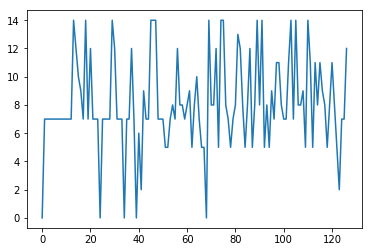

In [59]:
plt.plot(df_reindexed.loc[0,:]['topic'].values)